# Imports

In [ ]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import geodatasets
from sklearn.manifold import TSNE
import umap

# Load and preprocess data

In [90]:
# Load the CSV file into a DataFrame
df = pd.read_csv("temp_city_data/city_temperature.csv")

# Dropping the wrong 'AvgTemperature' entries
df = df[df['AvgTemperature'] != -99]

# Filter rows where Region is 'Europe' and select relevant columns
filtered_df = df[df['Region'] == 'Europe'][['AvgTemperature', 'Month', 'Year', 'City']]

# Convert AvgTemperature from Fahrenheit to Celsius
filtered_df['AvgTemperature'] = (filtered_df['AvgTemperature'] - 32) * 5.0/9.0

# Group by City and Month, and calculate the mean AvgTemperature for each group
avg_temp_by_month_city = filtered_df.groupby(['City', 'Month'])['AvgTemperature'].mean().reset_index()

# Pivot the table so that cities are columns, months are rows, and AvgTemperature is the value
temperature_matrix = avg_temp_by_month_city.pivot(index='Month', columns='City', values='AvgTemperature')

display(temperature_matrix)

C:\Users\Bruker\AppData\Local\Temp\ipykernel_21300\3211932938.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("temp_city_data/city_temperature.csv")


City,Amsterdam,Athens,Barcelona,Belfast,Belgrade,Bern,Bilbao,Bonn,Bordeaux,Bratislava,...,Skopje,Sofia,Stockholm,Tbilisi,Tirana,Vienna,Warsaw,Yerevan,Zagreb,Zurich
Month,,,,,,,,,,,,,,,,,,,,,
1,3.819981,10.070671,9.566625,5.554167,0.921337,0.493489,9.507315,2.083804,6.816867,-0.068440,...,0.368642,-1.110320,-1.560203,2.447321,6.965576,0.161139,-1.806905,-1.752708,1.400826,0.901965
2,4.377687,10.380780,10.203451,5.861490,3.297457,1.829549,9.646761,3.620072,7.425371,2.183848,...,3.356450,1.752797,-1.334469,3.910685,8.496210,2.317514,-0.202467,0.737937,3.504649,2.018165
3,6.415390,12.287988,12.240994,6.998689,7.576605,5.761491,11.789027,6.248366,10.252312,6.136922,...,7.747619,6.069193,1.176329,7.191592,11.598024,5.934036,3.259489,6.481681,7.952691,5.625604
4,9.898529,15.661513,14.521779,9.123282,12.983219,9.723436,13.442516,10.319946,12.797058,11.732933,...,12.367038,11.026441,6.103256,12.725221,14.829716,11.296772,9.355684,12.900206,12.956641,9.835052
5,13.378743,20.693943,17.710657,11.876685,17.685185,14.103532,16.253583,15.476667,16.156688,16.215544,...,17.293813,15.782432,11.195473,17.580482,19.166754,15.639989,14.542217,18.073939,17.550821,13.690537
6,16.071939,25.735346,21.786119,14.494258,21.352696,18.060322,19.304960,17.810345,19.641868,20.058088,...,21.778746,19.524597,15.659890,21.853675,23.517804,19.401177,17.873920,22.812579,21.461796,17.359473
7,18.117921,28.590643,24.490323,16.044086,23.118710,19.629414,21.159785,19.299102,21.305878,21.790609,...,24.266022,21.866487,18.563369,25.533759,25.690945,21.196846,19.767670,26.854042,22.962588,18.903943
8,18.050812,28.499476,24.895501,15.808330,23.052034,19.027202,21.572948,19.868863,21.312303,21.290283,...,24.133031,21.686332,17.595515,25.614858,25.653435,20.714327,19.130444,26.864795,22.589778,18.468552
9,15.253862,24.078804,21.906343,13.919827,17.859700,14.655065,19.541815,15.543423,18.324803,16.202094,...,18.759655,16.866605,12.947490,20.345250,21.461532,15.798128,14.049465,20.802043,17.268285,14.321524


# Real World Map of Cities

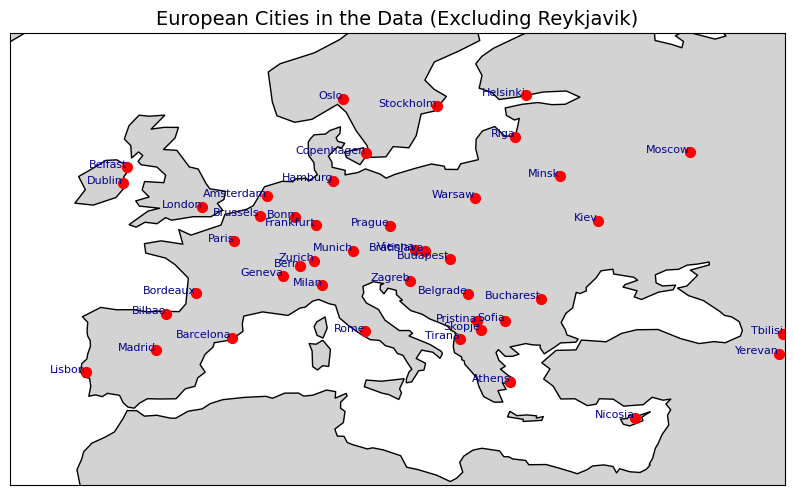

In [84]:
# Cities and their corresponding latitude and longitude (Reykjavik removed)
cities_data = {
    'City': ['Tirana', 'Vienna', 'Minsk', 'Brussels', 'Sofia', 'Zagreb', 'Nicosia', 'Prague',
             'Copenhagen', 'Helsinki', 'Paris', 'Bordeaux', 'Bonn', 'Frankfurt', 'Hamburg', 
             'Munich', 'Tbilisi', 'Athens', 'Budapest', 'Dublin', 'Milan', 'Rome', 
             'Riga', 'Skopje', 'Amsterdam', 'Oslo', 'Warsaw', 'Lisbon', 'Bucharest', 'Moscow', 
             'Yerevan', 'Pristina', 'Bratislava', 'Barcelona', 'Bilbao', 'Madrid', 'Stockholm', 
             'Bern', 'Geneva', 'Zurich', 'Kiev', 'Belfast', 'London', 'Belgrade'],
    'Latitude': [41.3275, 48.2082, 53.9006, 50.8503, 42.6975, 45.815, 35.1856, 50.0755,
                 55.6761, 60.1695, 48.8566, 44.8378, 50.7374, 50.1109, 53.5511, 48.1351, 
                 41.7151, 37.9838, 47.4979, 53.3498, 45.4642, 41.9028, 56.9496, 
                 41.9981, 52.3676, 59.9139, 52.2297, 38.7223, 44.4268, 55.7558, 
                 40.1792, 42.6629, 48.1486, 41.3851, 43.263, 40.4168, 59.3293, 
                 46.9481, 46.2044, 47.3769, 50.4501, 54.5973, 51.5074, 44.7866],
    'Longitude': [19.8189, 16.3738, 27.5590, 4.3517, 23.3222, 15.9819, 33.3823, 14.4378,
                  12.5683, 24.9354, 2.3522, -0.5792, 7.0982, 8.6821, 9.9937, 11.5820, 
                  44.8271, 23.7275, 19.0402, -6.2603, 9.1900, 12.4964, 24.1051, 
                  21.4317, 4.9041, 10.7522, 21.0122, -9.1393, 26.1025, 37.6173, 
                  44.4991, 21.1655, 17.1077, 2.1734, -2.9349, -3.7038, 18.0686, 
                  7.4474, 6.1432, 8.5417, 30.5234, -5.9301, -0.1276, 20.4489]
}

# Convert the data into a GeoDataFrame
gdf = gpd.GeoDataFrame(
    cities_data, 
    geometry=[Point(xy) for xy in zip(cities_data['Longitude'], cities_data['Latitude'])]
)

# Load a world map dataset using geodatasets
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the world map (zoomed into Europe)
world.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the cities on the map
gdf.plot(ax=ax, color='red', markersize=50, label='Cities')

# Annotate city names
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['City']):
    ax.text(x, y, label, fontsize=8, ha='right', color='darkblue')

# Zoom in by setting latitude and longitude limits for Europe
ax.set_xlim([-15, 45])  # Set longitude range (Western Europe)
ax.set_ylim([30, 65])   # Set latitude range (Southern Europe to Northern Europe)

# Remove latitude and longitude axis markings (numbers and labels)
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('')  # Remove y-axis label

# Set title
plt.title('European Cities in the Data (Excluding Reykjavik)', fontsize=14)

# Show the plot
plt.show()

# t-SNE Projection

In [ ]:
city_region_mapping = {
    'Tirana': 'Southern',
    'Vienna': 'Central',
    'Minsk': 'Eastern',
    'Brussels': 'Western',
    'Sofia': 'Eastern',
    'Zagreb': 'Eastern',
    'Nicosia': 'Southern',
    'Prague': 'Central',
    'Copenhagen': 'Northern',
    'Helsinki': 'Northern',
    'Paris': 'Western',
    'Bordeaux': 'Western',
    'Bonn': 'Central',
    'Frankfurt': 'Central',
    'Hamburg': 'Central',
    'Munich': 'Central',
    'Tbilisi': 'Eastern',
    'Athens': 'Southern',
    'Budapest': 'Eastern',
    'Reykjavik': 'Northern',
    'Dublin': 'Western',
    'Milan': 'Central',
    'Rome': 'Southern',
    'Riga': 'Northern',
    'Skopje': 'Eastern',
    'Amsterdam': 'Western',
    'Oslo': 'Northern',
    'Warsaw': 'Eastern',
    'Lisbon': 'Southern',
    'Bucharest': 'Eastern',
    'Moscow': 'Eastern',
    'Yerevan': 'Eastern',
    'Pristina': 'Eastern',
    'Bratislava': 'Central',
    'Barcelona': 'Southern',
    'Bilbao': 'Southern',
    'Madrid': 'Southern',
    'Stockholm': 'Northern',
    'Bern': 'Central',
    'Geneva': 'Central',
    'Zurich': 'Central',
    'Kiev': 'Eastern',
    'Belfast': 'Western',
    'London': 'Western',
    'Belgrade': 'Eastern',
    'Tallinn': 'Northern',
    'Vilnius': 'Eastern'
}

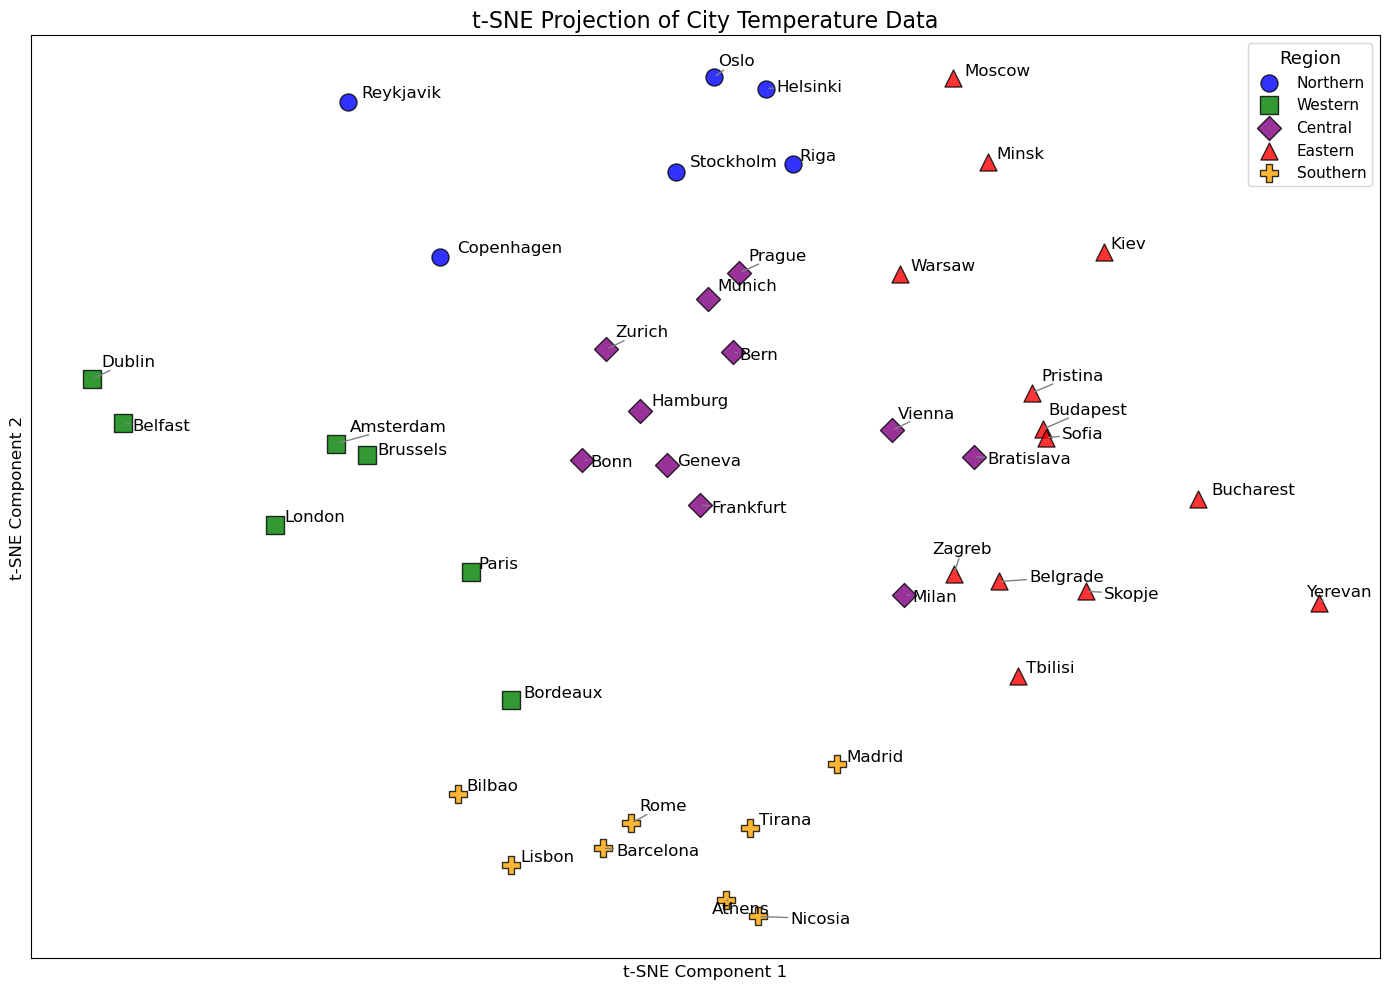

In [130]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Transpose the matrix so that cities are rows and months are columns (for t-SNE)
temperature_matrix_transposed = temperature_matrix.T.fillna(0)

# Apply t-SNE to reduce the data into 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(temperature_matrix_transposed)

# Assign regions to cities
regions = [city_region_mapping.get(city, 'Unknown') for city in temperature_matrix_transposed.index]

# Define color mapping for regions
region_colors = {
    'Northern': 'blue',
    'Western': 'green',
    'Central': 'purple',
    'Eastern': 'red',
    'Southern': 'orange'
}

# Define marker shapes for different regions
region_markers = {
    'Northern': 'o',
    'Western': 's',
    'Central': 'D',
    'Eastern': '^',
    'Southern': 'P'
}

# Plot the result with improved visibility
plt.figure(figsize=(14, 10))

# Scatter plot with different markers and colors for regions
for region in region_colors.keys():
    ix = [i for i, reg in enumerate(regions) if reg == region]
    plt.scatter(reduced_data[ix, 0], reduced_data[ix, 1], 
                c=region_colors[region], 
                marker=region_markers[region], 
                s=150, alpha=0.8, edgecolor='k', 
                label=region)

# Annotate each point with the city label
texts = []
for i, city in enumerate(temperature_matrix_transposed.index):
    texts.append(plt.text(reduced_data[i, 0], reduced_data[i, 1], city, fontsize=12))

# Use adjustText to prevent label overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=1))

# Add grid
# plt.grid(True, linestyle='--', alpha=0.6)

# Add legend with adjusted size
plt.legend(title='Region', title_fontsize='13', fontsize='11', loc='upper right')

# Add title and axis labels
plt.title('t-SNE Projection of City Temperature Data', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

plt.xticks([], []) # Remove x-axis ticks
plt.yticks([], [])  # Remove y-axis ticks

# Show plot
plt.tight_layout()
plt.show()


# UMAP

c:\Users\Bruker\anaconda3\envs\master\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


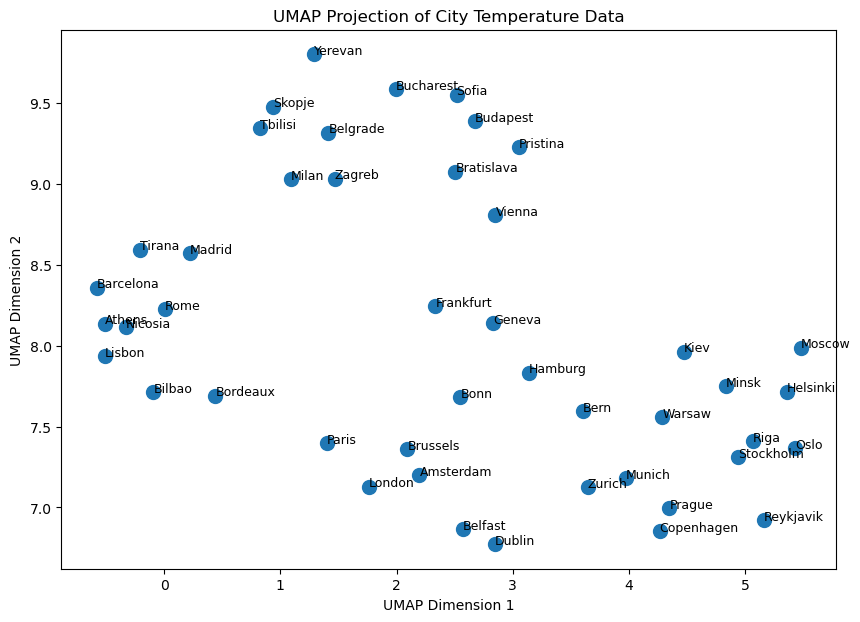

In [92]:
# Transpose the matrix so that cities are rows and months are columns (for UMAP)
temperature_matrix_transposed = temperature_matrix.T

# Apply UMAP to compress the data into 2D
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(temperature_matrix_transposed)

# Plot the result
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], s=100)

# Annotate each point with the city label
for i, city in enumerate(temperature_matrix_transposed.index):
    plt.text(embedding[i, 0], embedding[i, 1], city, fontsize=9)

plt.title('UMAP Projection of City Temperature Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()